<a href="https://colab.research.google.com/github/mgorsk1/gargabe-detector-app/blob/baseline/model/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os, glob

import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

Link to the data: https://drive.google.com/open?id=1m6-StcbywxvW95NsyibE7tl3PYRdlfcx

copy data to your google drive and modify `project_dir` below. 

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [0]:
project_dir = 'My Drive/projects/ING/Experiment_week/garbage_segmentation/'

data_train_dir = project_dir + 'data/raw/train/'
data_test_dir = project_dir + 'data/raw/test/'
models_dir = project_dir + 'models/'

In [21]:
classes = os.listdir(data_training_dir)
classes

['metal', 'paper', 'glass', 'plastic', 'cardboard']

In [22]:
os.listdir(data_test_dir)

['glass', 'cardboard', 'plastic', 'paper', 'metal']

In [0]:
def stack_images_and_labels(data_dir, do_save=True):
    file_paths = glob.glob(data_dir + '*/*')

    df_files = pd.DataFrame(file_paths, columns=['file_path'])
    df_files = df_files.assign(label=df_files['file_path'].str.split('/').apply(lambda x: x[-2]))

    images_list, labels_list = [], []
    for _, row in tqdm(df_files.iterrows(), total=len(df_files)):
        file_path = row[0]
        label = row[1]

        image = tf.keras.preprocessing.image.load_img(file_path, target_size=(224, 224))
        image = tf.keras.preprocessing.image.img_to_array(image)

        images_list.append(image)
        labels_list.append(label)

    images = np.stack(images_list)
    labels = np.stack(labels_list)

    if do_save:
        np.save(data_dir.replace('raw', 'processed') + 'images.npy', images)
        np.save(data_dir.replace('raw', 'processed') + 'labels.npy', labels)

    return images, labels

In [35]:
images_train, labels_train = stack_images_and_labels(data_train_dir)

In [34]:
images_test, labels_test = stack_images_and_labels(data_test_dir)

In [38]:
images_train = np.load(data_train_dir.replace('raw', 'processed') + 'images.npy')
labels_train = np.load(data_train_dir.replace('raw', 'processed') + 'labels.npy')
images_test = np.load(data_test_dir.replace('raw', 'processed') + 'images.npy')
labels_test = np.load(data_test_dir.replace('raw', 'processed') + 'labels.npy')

images_train.shape, labels_train.shape, images_test.shape, labels_test.shape

((3989, 224, 224, 3), (3989,), (102, 224, 224, 3), (102,))

In [0]:
def plot_images(images, labels):
    indices = np.random.choice(range(len(images)), size=10)
    fig, axs = plt.subplots(2, 5, figsize=(15, 5))
    axs = [j for i in axs for j in i]
    for i, index in enumerate(indices):
        axs[i].imshow(images[index].astype(int)) 
        axs[i].set_title(labels[index])

    plt.tight_layout()

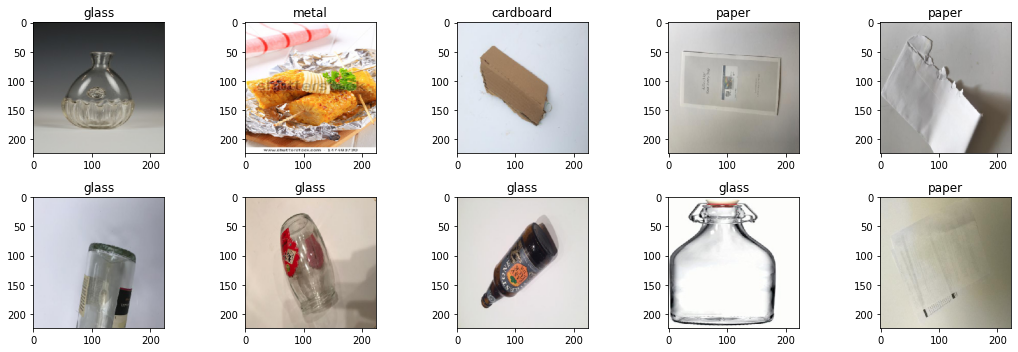

In [43]:
plot_images(images_train, labels_train)

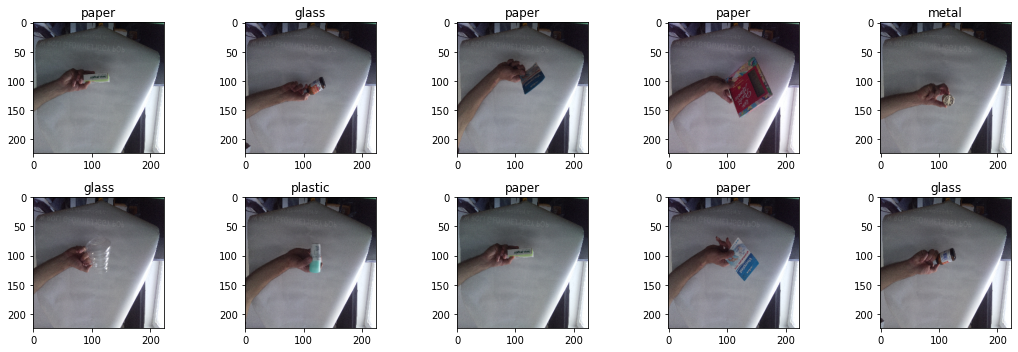

In [44]:
plot_images(images_test, labels_test)

In [0]:
def compute_image_embedding(images, model, preprocess_input, input_shape, data_dir, do_save=True):
    images_preped = preprocess_input(np.copy(images))
    images_embedding = model.predict(images_preped, batch_size=32, verbose=1)
    if do_save:
        np.save(data_dir.replace('raw', 'processed') + 'images_embedding.npy', images_embedding)
    return images_embedding

In [0]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input
input_shape = (224, 224, 3)

model_base = tf.keras.applications.resnet50.ResNet50(include_top=False, input_shape=input_shape)

In [51]:
images_embedding_train = compute_image_embedding(images_train, model_base, preprocess_input, input_shape, data_train_dir)

125/125 [==============================] - 26s 206ms/step


In [50]:
images_embedding_test = compute_image_embedding(images_test, model_base, preprocess_input, input_shape, data_test_dir)

4/4 [==============================] - 1s 128ms/step


In [54]:
images_embedding_train = np.load(data_train_dir.replace('raw', 'processed') + 'images_embedding.npy')
labels_train = np.load(data_train_dir.replace('raw', 'processed') + 'labels.npy')

images_embedding_train.shape, labels_train.shape

((3989, 7, 7, 2048), (3989,))

In [55]:
images_embedding_test = np.load(data_test_dir.replace('raw', 'processed') + 'images_embedding.npy')
labels_test = np.load(data_test_dir.replace('raw', 'processed') + 'labels.npy')

images_embedding_test.shape, labels_test.shape

((102, 7, 7, 2048), (102,))

In [57]:
images_embedding_train.mean(), images_embedding_train.std()

(0.4421334, 1.671736)

In [58]:
images_embedding_test.mean(), images_embedding_test.std()

(0.6329852, 1.960072)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [60]:
images_embedding_train, images_embedding_val, labels_train, labels_val = train_test_split(images_embedding_train, labels_train, random_state=1)
images_embedding_train.shape

(2991, 7, 7, 2048)

In [0]:
def to_categorical(labels, label_to_index):
    labels_int = pd.Series(labels).map(label_to_index)
    return tf.keras.utils.to_categorical(labels_int, num_classes=len(label_to_index)) 

In [0]:
label_to_index = dict(zip(classes, range(len(classes))))

labels_train_c = to_categorical(labels_train, label_to_index)
labels_val_c = to_categorical(labels_val, label_to_index)
labels_test_c = to_categorical(labels_test, label_to_index)

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])

In [0]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False)
)

In [65]:
new_learning_rate = 0.001

print('current_learning_rate', tf.keras.backend.get_value(model.optimizer.lr))
tf.keras.backend.set_value(model.optimizer.lr, new_learning_rate)
print('current_learning_rate', tf.keras.backend.get_value(model.optimizer.lr))

current_learning_rate 0.001
current_learning_rate 0.001


In [66]:
model.fit(
    images_embedding_train, 
    labels_train_c,
    validation_data=(images_embedding_val, labels_val_c),
    validation_freq=10,
    batch_size=32, 
    epochs=100
)

Epoch 1/100
94/94 [==============================] - 5s 53ms/step - loss: 3.3446
Epoch 2/100
94/94 [==============================] - 5s 53ms/step - loss: 0.7526
Epoch 3/100
94/94 [==============================] - 5s 52ms/step - loss: 0.5779
Epoch 4/100
94/94 [==============================] - 5s 52ms/step - loss: 0.4219
Epoch 5/100
94/94 [==============================] - 5s 52ms/step - loss: 0.2799
Epoch 6/100
94/94 [==============================] - 5s 52ms/step - loss: 0.2103
Epoch 7/100
94/94 [==============================] - 5s 52ms/step - loss: 0.1471
Epoch 8/100
94/94 [==============================] - 5s 52ms/step - loss: 0.1345
Epoch 9/100
94/94 [==============================] - 5s 53ms/step - loss: 0.0984
Epoch 10/100
94/94 [==============================] - 6s 59ms/step - loss: 0.0888 - val_loss: 0.7316
Epoch 11/100
94/94 [==============================] - 5s 52ms/step - loss: 0.1204
Epoch 12/100
94/94 [==============================] - 5s 52ms/step - loss: 0.1102
Epoch 

In [0]:
model.save(models_dir + 'model0.h5')

In [71]:
prediction_train = model.predict(images_embedding_train)

print(
    classification_report(
        labels_train_c.argmax(axis=1), 
        prediction_train.argmax(axis=1), 
        target_names=classes
    )
)

              precision    recall  f1-score   support

       metal       0.99      1.00      1.00       630
       paper       1.00      1.00      1.00       629
       glass       1.00      1.00      1.00       730
     plastic       1.00      0.99      1.00       698
   cardboard       1.00      1.00      1.00       304

    accuracy                           1.00      2991
   macro avg       1.00      1.00      1.00      2991
weighted avg       1.00      1.00      1.00      2991



In [72]:
prediction_val = model.predict(images_embedding_val)

print(
    classification_report(
        labels_val_c.argmax(axis=1), 
        prediction_val.argmax(axis=1), 
        target_names=classes
    )
)

              precision    recall  f1-score   support

       metal       0.78      0.93      0.84       216
       paper       0.89      0.93      0.91       224
       glass       0.89      0.85      0.87       223
     plastic       0.94      0.79      0.86       236
   cardboard       0.96      0.91      0.93        99

    accuracy                           0.88       998
   macro avg       0.89      0.88      0.88       998
weighted avg       0.88      0.88      0.88       998



In [73]:
prediction_test = model.predict(images_embedding_test)

print(
    classification_report(
        labels_test_c.argmax(axis=1), 
        prediction_test.argmax(axis=1), 
        target_names=classes
    )
)

              precision    recall  f1-score   support

       metal       0.50      0.29      0.37        24
       paper       0.22      0.84      0.35        19
       glass       0.50      0.10      0.17        20
     plastic       0.36      0.12      0.18        33
   cardboard       0.00      0.00      0.00         6

    accuracy                           0.28       102
   macro avg       0.32      0.27      0.21       102
weighted avg       0.37      0.28      0.24       102

